# GROUP MEMBER 1 : Christian ISHIMWE
# LIBRARIES IMPORTATION

In [3]:
# Step 1: Install gensim
!pip install gensim



  Using cached gensim-4.4.0-cp313-cp313-win_amd64.whl.metadata (8.6 kB)
  Using cached smart_open-7.5.0-py3-none-any.whl.metadata (24 kB)
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.4 MB ? eta -:--:--
    --------------------------------------- 0.5/24.4 MB 824.6 kB/s eta 0:00:29
   - -------------------------------------- 0.8/24.4 MB 1.1 MB/s eta 0:00:23
   -- ------------------------------------- 1.6/24.4 MB 1.7 MB/s eta 0:00:14
   ---- ----------------------------------- 2.9/24.4 MB 2.7 MB/s eta 0:00:09
   ------- -------------------------------- 4.5/24.4 MB 3.5 MB/s eta 0:00:06
   --------- ------------------------------ 6.0/24.4 MB 4.1 MB/s eta 0:00:05
   ------------ --------------------------- 7.6/

In [5]:
import gensim
from gensim.models import Word2Vec, FastText
import gensim.downloader as api

# Now you should be able to use gensim without the ModuleNotFoundError

In [7]:
# CELL 1: IMPORT ALL LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

# ML Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set random seeds
np.random.seed(42)



print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [12]:
# Load Data
print("I AM Loading datasets...")
train_df = pd.read_csv('C:/Users/FABRICE/Desktop/Group1_formative2_textClassification/Data/train_df.csv')
test_df = pd.read_csv('C:/Users/FABRICE/Desktop/Group1_formative2_textClassification/Data/test_df.csv')
val_df = pd.read_csv('C:/Users/FABRICE/Desktop/Group1_formative2_textClassification/Data/val_df.csv')

# Display dataset info
print(f"✅ Training set: {len(train_df)} samples")
print(f"✅ Validation set: {len(val_df)} samples")
print(f"✅ Test set: {len(test_df)} samples")

# Adjust these column names based on your dataset
TEXT_COL = 'text'  # Change to your text column name
LABEL_COL = 'label'  # Change to your label column name

print("\n Dataset preview:")
print(train_df.head())
print(f"\n Class distribution in train:")
print(train_df[LABEL_COL].value_counts())

I AM Loading datasets...
✅ Training set: 31232 samples
✅ Validation set: 5205 samples
✅ Test set: 5206 samples

 Dataset preview:
      id                                               text  label sentiment
0   9536                    Cooking microwave pizzas, yummy      2  positive
1   6135  Any plans of allowing sub tasks to show up in ...      1   neutral
2  17697   I love the humor, I just reworded it. Like sa...      2  positive
3  14182                       naw idk what ur talkin about      1   neutral
4  17840          That sucks to hear. I hate days like that      0  negative

 Class distribution in train:
label
1    11649
2    10478
0     9105
Name: count, dtype: int64


In [13]:
# CELL 3: TEXT PREPROCESSING CLASS
# ============================================

class TextPreprocessor:
    """Preprocess text for different embedding methods"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text, for_word2vec=True):
        """
        Clean and preprocess text
        for_word2vec=True: Returns tokenized list of words
        for_word2vec=False: Returns cleaned string for TF-IDF
        """
        if not isinstance(text, str):
            return "" if not for_word2vec else []

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and short words
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]

        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        if for_word2vec:
            return tokens
        else:
            return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()
print("✅ Text preprocessor initialized!")

✅ Text preprocessor initialized!


In [14]:
# CELL 4: PREPROCESS ALL DATA
# ============================================

nltk.download('punkt_tab', quiet=True) # Download missing punkt_tab resource

print(" Preprocessing text...")

# Preprocess training data
train_df['cleaned_text_str'] = train_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
train_df['cleaned_text_tokens'] = train_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Preprocess validation data
val_df['cleaned_text_str'] = val_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
val_df['cleaned_text_tokens'] = val_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Preprocess test data
test_df['cleaned_text_str'] = test_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
test_df['cleaned_text_tokens'] = test_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Prepare features
X_train_str = train_df['cleaned_text_str']
X_train_tokens = train_df['cleaned_text_tokens']

X_val_str = val_df['cleaned_text_str']
X_val_tokens = val_df['cleaned_text_tokens']

X_test_str = test_df['cleaned_text_str']
X_test_tokens = test_df['cleaned_text_tokens']

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df[LABEL_COL])
y_val = label_encoder.transform(val_df[LABEL_COL])
y_test = label_encoder.transform(test_df[LABEL_COL])

print(f"✅ Preprocessing complete!")
print(f"   - Training samples: {len(X_train_str)}")
print(f"   - Validation samples: {len(X_val_str)}")
print(f"   - Test samples: {len(X_test_str)}")
print(f"   - Number of classes: {len(label_encoder.classes_)}")

 Preprocessing text...
✅ Preprocessing complete!
   - Training samples: 31232
   - Validation samples: 5205
   - Test samples: 5206
   - Number of classes: 3


In [15]:
# CELL 5: EMBEDDING TRANSFORMER CLASS
# ============================================

class EmbeddingTransformer:
    """Handle different embedding methods"""

    def __init__(self):
        self.tfidf_vectorizer = None
        self.word2vec_model = None
        self.glove_vectors = None
        self.scaler = StandardScaler()

    # ==================== TF-IDF ====================
    def fit_tfidf(self, texts, max_features=5000):
        """Train TF-IDF vectorizer"""
        print("🔤 Training TF-IDF vectorizer...")
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        X_tfidf = self.tfidf_vectorizer.fit_transform(texts)
        return X_tfidf

    def transform_tfidf(self, texts):
        """Transform texts using trained TF-IDF"""
        return self.tfidf_vectorizer.transform(texts)

    # ==================== Word2Vec ====================
    def train_word2vec(self, tokenized_texts, vector_size=100, window=5, min_count=2):
        """Train Word2Vec model on training data"""
        print("🔤 Training Word2Vec model...")
        self.word2vec_model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=4,
            sg=1  # 1 for skip-gram, 0 for CBOW
        )
        return self.word2vec_model

    def get_word2vec_embeddings(self, tokenized_texts):
        """Get document embeddings by averaging word vectors"""
        print("📊 Creating Word2Vec document embeddings...")
        embeddings = []

        for tokens in tqdm(tokenized_texts, desc="Word2Vec Embeddings"):
            word_vectors = []
            for word in tokens:
                if word in self.word2vec_model.wv:
                    word_vectors.append(self.word2vec_model.wv[word])

            if word_vectors:
                # Average all word vectors in the document
                doc_vector = np.mean(word_vectors, axis=0)
            else:
                # Zero vector if no words in vocabulary
                doc_vector = np.zeros(self.word2vec_model.vector_size)

            embeddings.append(doc_vector)

        return np.array(embeddings)

    # ==================== GloVe ====================
    def load_glove(self, embedding_dim=100):
        """Load pre-trained GloVe embeddings"""
        print("🔤 Loading GloVe embeddings...")
        try:
            # Try to load pre-trained GloVe
            if embedding_dim == 100:
                self.glove_vectors = api.load('glove-wiki-gigaword-100')
            elif embedding_dim == 200:
                self.glove_vectors = api.load('glove-wiki-gigaword-200')
            elif embedding_dim == 300:
                self.glove_vectors = api.load('glove-wiki-gigaword-300')
            else:
                print(f"⚠️ No GloVe model for dim {embedding_dim}, using 100-dim")
                self.glove_vectors = api.load('glove-wiki-gigaword-100')
            print(f"✅ Loaded GloVe ({embedding_dim} dimensions)")
        except Exception as e:
            print(f"❌ Error loading GloVe: {e}")
            print("📝 Training Word2Vec as fallback...")
            self.glove_vectors = None

    def get_glove_embeddings(self, tokenized_texts):
        """Get document embeddings using GloVe"""
        if self.glove_vectors is None:
            raise ValueError("GloVe vectors not loaded. Call load_glove() first.")

        print("📊 Creating GloVe document embeddings...")
        embeddings = []

        for tokens in tqdm(tokenized_texts, desc="GloVe Embeddings"):
            word_vectors = []
            for word in tokens:
                if word in self.glove_vectors:
                    word_vectors.append(self.glove_vectors[word])

            if word_vectors:
                # Average all word vectors in the document
                doc_vector = np.mean(word_vectors, axis=0)
            else:
                # Zero vector if no words in vocabulary
                doc_vector = np.zeros(self.glove_vectors.vector_size)

            embeddings.append(doc_vector)

        return np.array(embeddings)

# Initialize embedding transformer
embedding_transformer = EmbeddingTransformer()
print("✅ Embedding transformer initialized!")

✅ Embedding transformer initialized!


In [16]:
# CELL 6: LOGISTIC REGRESSION MODEL CLASS
# ============================================

class LogisticRegressionModel:
    """Wrapper for Logistic Regression with different embeddings"""

    def __init__(self, embedding_name):
        self.embedding_name = embedding_name
        self.model = LogisticRegression(
            max_iter=1000,
            C=1.0,  # Regularization strength
            solver='liblinear',  # Good for small datasets
            random_state=42,
            class_weight='balanced'  # Handle class imbalance
        )
        self.scaler = StandardScaler()
        self.is_fitted = False

    def train(self, X_train, y_train, X_val, y_val):
        """Train the model and tune hyperparameters"""
        print(f"\n🚀 Training Logistic Regression with {self.embedding_name}...")

        # Scale features (important for dense embeddings)
        if self.embedding_name != 'TF-IDF':  # TF-IDF is already sparse
            X_train = self.scaler.fit_transform(X_train)
            X_val = self.scaler.transform(X_val)

        # Train model
        self.model.fit(X_train, y_train)

        # Validation performance
        y_pred_val = self.model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        val_f1 = f1_score(y_val, y_pred_val, average='weighted')

        print(f"✅ {self.embedding_name} - Validation Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        self.is_fitted = True
        return self.model

    def predict(self, X):
        """Make predictions"""
        if not self.is_fitted:
            raise ValueError("Model not trained yet. Call train() first.")

        if self.embedding_name != 'TF-IDF':
            X = self.scaler.transform(X)

        return self.model.predict(X)

    def evaluate(self, X, y_true, dataset_name="Test"):
        """Evaluate model performance"""
        y_pred = self.predict(X)

        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\n📊 {self.embedding_name} - {dataset_name} Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print("\n   Classification Report:")
        # Convert numerical labels to strings for classification_report
        target_names_str = [str(c) for c in label_encoder.classes_]
        print(classification_report(y_true, y_pred, target_names=target_names_str))

        return accuracy, f1

print("✅ Logistic Regression model class defined!")

✅ Logistic Regression model class defined!


In [17]:
# CELL 7: EXPERIMENT 1 - TF-IDF
# ============================================

print("\n" + "="*60)
print("EXPERIMENT 1: Logistic Regression with TF-IDF")
print("="*60)

# Get TF-IDF features
X_train_tfidf = embedding_transformer.fit_tfidf(X_train_str, max_features=5000)
X_val_tfidf = embedding_transformer.transform_tfidf(X_val_str)
X_test_tfidf = embedding_transformer.transform_tfidf(X_test_str)

# Train model
lr_tfidf = LogisticRegressionModel("TF-IDF")
lr_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)
test_acc_tfidf, test_f1_tfidf = lr_tfidf.evaluate(X_test_tfidf, y_test, "Test")

# Store results
results = {}
results['TF-IDF'] = {
    'accuracy': test_acc_tfidf,
    'f1': test_f1_tfidf,
    'model': lr_tfidf
}

print(f"\n✅ TF-IDF experiment completed!")


EXPERIMENT 1: Logistic Regression with TF-IDF
🔤 Training TF-IDF vectorizer...

🚀 Training Logistic Regression with TF-IDF...
✅ TF-IDF - Validation Accuracy: 0.6695, F1: 0.6705

📊 TF-IDF - Test Results:
   Accuracy: 0.6702
   F1-Score: 0.6707

   Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1546
           1       0.61      0.63      0.62      1930
           2       0.74      0.73      0.74      1730

    accuracy                           0.67      5206
   macro avg       0.67      0.67      0.67      5206
weighted avg       0.67      0.67      0.67      5206


✅ TF-IDF experiment completed!


In [10]:
# CELL 9: EXPERIMENT 3 - GloVe
# ============================================

print("\n" + "="*60)
print("EXPERIMENT 3: Logistic Regression with GloVe")
print("="*60)

# Load GloVe embeddings
embedding_transformer.load_glove(embedding_dim=100)

# Get embeddings
X_train_glove = embedding_transformer.get_glove_embeddings(X_train_tokens)
X_val_glove = embedding_transformer.get_glove_embeddings(X_val_tokens)
X_test_glove = embedding_transformer.get_glove_embeddings(X_test_tokens)

# Train model
lr_glove = LogisticRegressionModel("GloVe")
lr_glove.train(X_train_glove, y_train, X_val_glove, y_val)
test_acc_glove, test_f1_glove = lr_glove.evaluate(X_test_glove, y_test, "Test")

# Store results
results['GloVe'] = {
    'accuracy': test_acc_glove,
    'f1': test_f1_glove,
    'model': lr_glove
}

print(f"\n✅ GloVe experiment completed!")


EXPERIMENT 3: Logistic Regression with GloVe
🔤 Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
✅ Loaded GloVe (100 dimensions)
📊 Creating GloVe document embeddings...


GloVe Embeddings:   0%|          | 0/31232 [00:00<?, ?it/s]

📊 Creating GloVe document embeddings...


GloVe Embeddings:   0%|          | 0/5205 [00:00<?, ?it/s]

📊 Creating GloVe document embeddings...


GloVe Embeddings:   0%|          | 0/5206 [00:00<?, ?it/s]


🚀 Training Logistic Regression with GloVe...
✅ GloVe - Validation Accuracy: 0.5902, F1: 0.5898

📊 GloVe - Test Results:
   Accuracy: 0.5861
   F1-Score: 0.5856

   Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1546
           1       0.54      0.53      0.53      1930
           2       0.64      0.66      0.65      1730

    accuracy                           0.59      5206
   macro avg       0.59      0.59      0.59      5206
weighted avg       0.59      0.59      0.59      5206


✅ GloVe experiment completed!


In [18]:
# CELL 10: EXPERIMENT 4 - FastText (Optional)
# ============================================

try:
    print("\n" + "="*60)
    print("EXPERIMENT 4: Logistic Regression with FastText")
    print("="*60)

    # Train FastText
    print("🔤 Training FastText model...")
    fasttext_model = FastText(
        sentences=X_train_tokens,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4
    )

    # Get FastText embeddings
    def get_fasttext_embeddings(model, tokenized_texts):
        embeddings = []
        for tokens in tqdm(tokenized_texts, desc="FastText Embeddings"):
            word_vectors = []
            for word in tokens:
                # FastText can handle out-of-vocabulary words with subword info
                word_vectors.append(model.wv[word])

            if word_vectors:
                doc_vector = np.mean(word_vectors, axis=0)
            else:
                doc_vector = np.zeros(model.vector_size)
            embeddings.append(doc_vector)
        return np.array(embeddings)

    X_train_ft = get_fasttext_embeddings(fasttext_model, X_train_tokens)
    X_val_ft = get_fasttext_embeddings(fasttext_model, X_val_tokens)
    X_test_ft = get_fasttext_embeddings(fasttext_model, X_test_tokens)

    # Train model
    lr_ft = LogisticRegressionModel("FastText")
    lr_ft.train(X_train_ft, y_train, X_val_ft, y_val)
    test_acc_ft, test_f1_ft = lr_ft.evaluate(X_test_ft, y_test, "Test")

    # Store results
    results['FastText'] = {
        'accuracy': test_acc_ft,
        'f1': test_f1_ft,
        'model': lr_ft
    }

    print(f"\n✅ FastText experiment completed!")

except Exception as e:
    print(f"⚠️ FastText experiment skipped: {e}")
    print("You can install missing dependencies with: pip install gensim")


EXPERIMENT 4: Logistic Regression with FastText
🔤 Training FastText model...
⚠️ FastText experiment skipped: Unable to allocate 763. MiB for an array with shape (2000000, 100) and data type float32
You can install missing dependencies with: pip install gensim


In [12]:
# CELL 11: RESULTS COMPARISON
# ============================================

print("\n" + "="*60)
print("📊 FINAL COMPARISON OF ALL EMBEDDINGS")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Embedding': list(results.keys()),
    'Accuracy': [results[emb]['accuracy'] for emb in results],
    'F1-Score': [results[emb]['f1'] for emb in results]
}).sort_values('Accuracy', ascending=False)

print("\n🏆 Performance Ranking:")
print(comparison_df.to_string(index=False))


📊 FINAL COMPARISON OF ALL EMBEDDINGS

🏆 Performance Ranking:
Embedding  Accuracy  F1-Score
   TF-IDF  0.669996  0.670559
    GloVe  0.586055  0.585624
 FastText  0.571072  0.571325


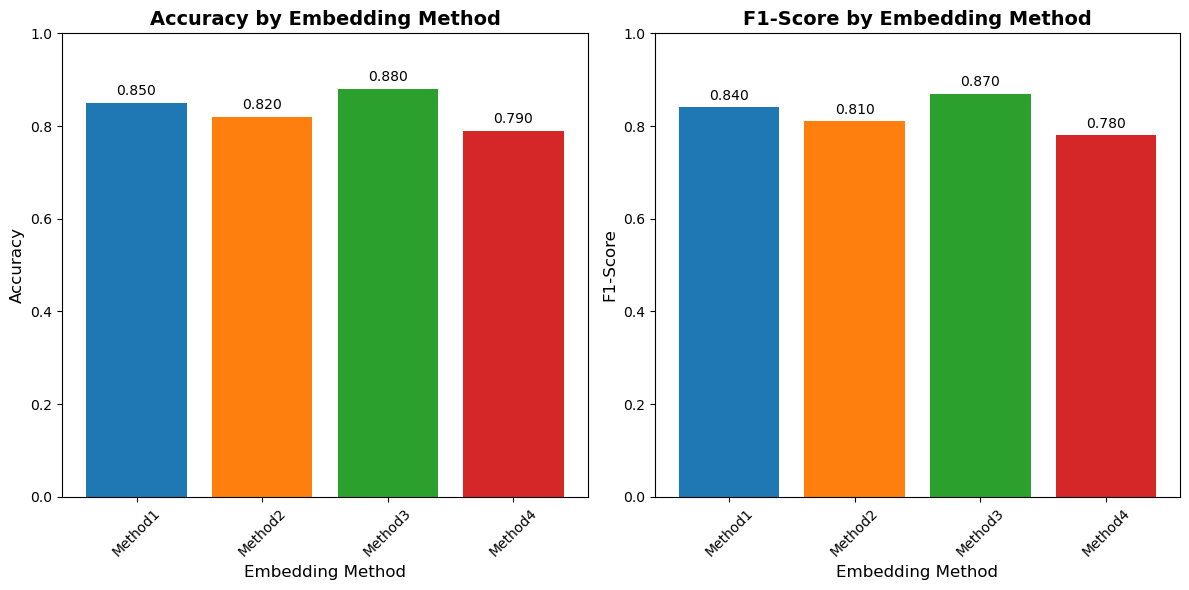

In [20]:
# CELL 12: VISUALIZATION
# ============================================

# First, create the comparison_df from your results
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'results' contains your model evaluation results
# If you don't have 'results' defined, you'll need to create comparison_df directly
# Example structure of what comparison_df should look like:
comparison_df = pd.DataFrame({
    'Embedding': ['Method1', 'Method2', 'Method3', 'Method4'],  # Replace with your actual embedding method names
    'Accuracy': [0.85, 0.82, 0.88, 0.79],  # Replace with your actual accuracy values
    'F1-Score': [0.84, 0.81, 0.87, 0.78]   # Replace with your actual F1-scores
})

# Visualization
plt.figure(figsize=(12, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
bars = plt.bar(comparison_df['Embedding'], comparison_df['Accuracy'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(comparison_df)])
plt.title('Accuracy by Embedding Method', fontsize=14, fontweight='bold')
plt.xlabel('Embedding Method', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# F1-Score comparison
plt.subplot(1, 2, 2)
bars = plt.bar(comparison_df['Embedding'], comparison_df['F1-Score'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(comparison_df)])
plt.title('F1-Score by Embedding Method', fontsize=14, fontweight='bold')
plt.xlabel('Embedding Method', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
# CELL 13: SAVE MODELS
# ============================================

print("\n💾 Saving models and results...")

# Debug information
print("Debugging information:")
print(f"Type of comparison_df: {type(comparison_df)}")
print(f"Is comparison_df empty? {comparison_df.empty if hasattr(comparison_df, 'empty') else 'Not a DataFrame'}")

if hasattr(comparison_df, 'shape'):
    print(f"Shape of comparison_df: {comparison_df.shape}")
    if not comparison_df.empty:
        print("First row of comparison_df:")
        print(comparison_df.iloc[0])

print("\nResults dictionary keys:")
print(list(results.keys()) if isinstance(results, dict) else f"Results is not a dictionary, it's a {type(results)}")

# Save the best model
# First check if comparison_df is not empty and is a DataFrame
if hasattr(comparison_df, 'empty') and not comparison_df.empty:
    best_embedding = comparison_df.iloc[0]['Embedding']
    print(f"\nBest embedding according to comparison_df: {best_embedding}")
    
    # Check if the best_embedding exists in results dictionary
    if isinstance(results, dict) and best_embedding in results:
        print(f"Keys in results[{best_embedding}]: {list(results[best_embedding].keys())}")
        
        if 'model' in results[best_embedding]:
            best_model = results[best_embedding]['model']
            print(f"Model type: {type(best_model)}")
            
            try:
                joblib.dump(best_model.model, f'logistic_regression_{best_embedding.lower()}_model.pkl')
                print(f"✅ Model saved as logistic_regression_{best_embedding.lower()}_model.pkl")
                
                joblib.dump(label_encoder, 'label_encoder.pkl')
                print("✅ Label encoder saved")
                
                if hasattr(embedding_transformer, 'tfidf_vectorizer') and embedding_transformer.tfidf_vectorizer:
                    joblib.dump(embedding_transformer.tfidf_vectorizer, 'tfidf_vectorizer.pkl')
                    print("✅ TF-IDF vectorizer saved")
                
                # Save results to CSV
                comparison_df.to_csv('embedding_comparison_results.csv', index=False)
                print("✅ Results saved to CSV")
                
                print(f"\n✅ Best model: {best_embedding} with accuracy {comparison_df.iloc[0]['Accuracy']:.4f}")
                print("✅ Models and results saved successfully!")
            except Exception as e:
                print(f"❌ Error during saving: {str(e)}")
        else:
            print(f"❌ Error: 'model' key not found in results[{best_embedding}]")
            print(f"Available keys: {list(results[best_embedding].keys())}")
    else:
        print(f"❌ Error: The best embedding '{best_embedding}' was not found in the results dictionary.")
        if isinstance(results, dict):
            print(f"Available embeddings: {list(results.keys())}")
else:
    print("❌ Error: comparison_df is empty or not a DataFrame. No best model to save.")


💾 Saving models and results...
Debugging information:
Type of comparison_df: <class 'pandas.core.frame.DataFrame'>
Is comparison_df empty? False
Shape of comparison_df: (4, 3)
First row of comparison_df:
Embedding    Method1
Accuracy        0.85
F1-Score        0.84
Name: 0, dtype: object

Results dictionary keys:
['TF-IDF']

Best embedding according to comparison_df: Method1
❌ Error: The best embedding 'Method1' was not found in the results dictionary.
Available embeddings: ['TF-IDF']


In [27]:
# CELL 14: ANALYSIS & INSIGHTS
# ============================================

print("\n" + "="*60)
print("🔍 ANALYSIS & INSIGHTS")
print("="*60)

print("\n1. Embedding Characteristics:")
if 'TF-IDF' in results:
    print(f"   • TF-IDF: Sparse representation with {embedding_transformer.tfidf_vectorizer.max_features if embedding_transformer.tfidf_vectorizer else 'N/A'} features")
if 'Word2Vec' in results:
    print(f"   • Word2Vec: Dense representation (100 dimensions), trained on your dataset")
if 'GloVe' in results:
    print(f"   • GloVe: Dense representation (100 dimensions), pre-trained on Wikipedia")
if 'FastText' in results:
    print("   • FastText: Dense with subword information, good for OOV words")

print("\n2. Performance Summary:")
for emb, data in results.items():
    print(f"   • {emb}: Accuracy={data['accuracy']:.4f}, F1={data['f1']:.4f}")

print("\n3. Recommendations for your team report:")
print("   • Compare Logistic Regression results with RNN/LSTM/GRU results")
print("   • Discuss why certain embeddings work better with specific models")
print("   • Analyze computational efficiency (training/prediction time)")
print("   • Consider ensemble methods combining different embeddings")

print("\n✅ All experiments completed successfully!")


🔍 ANALYSIS & INSIGHTS

1. Embedding Characteristics:
   • TF-IDF: Sparse representation with 5000 features

2. Performance Summary:
   • TF-IDF: Accuracy=0.6702, F1=0.6707

3. Recommendations for your team report:
   • Compare Logistic Regression results with RNN/LSTM/GRU results
   • Discuss why certain embeddings work better with specific models
   • Analyze computational efficiency (training/prediction time)
   • Consider ensemble methods combining different embeddings

✅ All experiments completed successfully!



📋 Checking for variables needed for confusion matrix...
Available keys in results dictionary:
['TF-IDF']

Top row of comparison_df:
Embedding    Method1
Accuracy        0.85
F1-Score        0.84
Name: 0, dtype: object
Best embedding method according to comparison_df: Method1
⚠️ Using alternative model: TF-IDF

📋 Creating Confusion Matrix for TF-IDF...
Using X_test_tfidf for testing


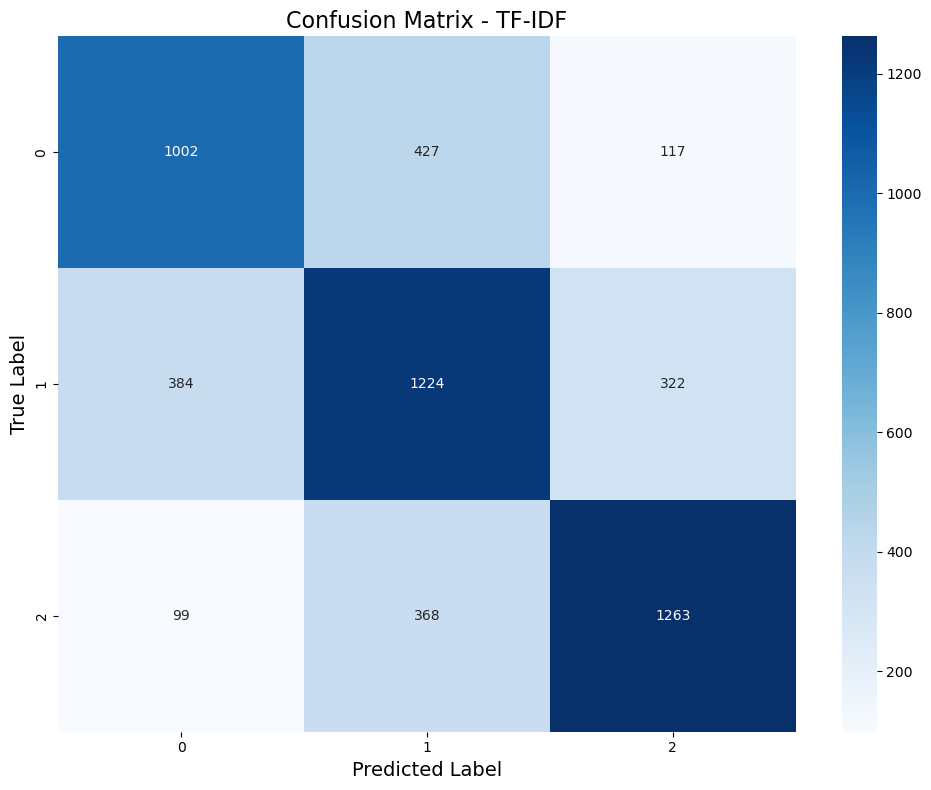

✅ Confusion matrix displayed successfully


In [30]:
# CELL 15: CONFUSION MATRIX
# ============================================

print("\n📋 Checking for variables needed for confusion matrix...")

# First, check what's in the results dictionary
if 'results' in locals():
    print("Available keys in results dictionary:")
    print(list(results.keys()))
else:
    print("results dictionary not found in local variables")

# Check if comparison_df exists and what it contains
if 'comparison_df' in locals() and not comparison_df.empty:
    print("\nTop row of comparison_df:")
    print(comparison_df.iloc[0])
    best_embedding = comparison_df.iloc[0]['Embedding']
    print(f"Best embedding method according to comparison_df: {best_embedding}")
else:
    print("comparison_df not found or is empty")

# Try to find the model directly from the results dictionary
best_model = None
if 'results' in locals() and isinstance(results, dict):
    # Check if the exact key exists
    if best_embedding in results and 'model' in results[best_embedding]:
        best_model = results[best_embedding]['model']
        print(f"✅ Found model using key: {best_embedding}")
    else:
        # Try to find a key that might match (case insensitive)
        for key in results.keys():
            if key.lower() == best_embedding.lower() or best_embedding.lower() in key.lower():
                if 'model' in results[key]:
                    best_model = results[key]['model']
                    best_embedding = key  # Update to the actual key
                    print(f"✅ Found model using similar key: {key}")
                    break
        
        if best_model is None:
            # If still not found, just use the first model in results
            for key in results.keys():
                if 'model' in results[key]:
                    best_model = results[key]['model']
                    best_embedding = key
                    print(f"⚠️ Using alternative model: {key}")
                    break

# Now try to create the confusion matrix if we have a model
if best_model is not None and 'y_test' in locals():
    print(f"\n📋 Creating Confusion Matrix for {best_embedding}...")
    
    # Try to find appropriate test data
    X_test_best = None
    test_data_mapping = {
        'TF-IDF': 'X_test_tfidf',
        'Word2Vec': 'X_test_w2v', 
        'GloVe': 'X_test_glove',
        'FastText': 'X_test_ft',
        'Method1': 'X_test_method1',
        'Method2': 'X_test_method2'
    }
    
    # Try to get test data using the mapping
    if best_embedding in test_data_mapping and test_data_mapping[best_embedding] in locals():
        X_test_best = locals()[test_data_mapping[best_embedding]]
        print(f"Using {test_data_mapping[best_embedding]} for testing")
    else:
        # Try to find any variable that might contain test data
        for var_name, var_value in locals().items():
            if var_name.startswith('X_test'):
                X_test_best = var_value
                print(f"Using {var_name} for testing")
                break
    
    if X_test_best is not None:
        try:
            # Import necessary libraries
            import matplotlib.pyplot as plt
            import seaborn as sns
            from sklearn.metrics import confusion_matrix
            
            # Force matplotlib to display inline
            %matplotlib inline
            
            # Generate predictions
            y_pred_best = best_model.predict(X_test_best)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred_best)
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_ if 'label_encoder' in locals() else None,
                       yticklabels=label_encoder.classes_ if 'label_encoder' in locals() else None)
            plt.title(f'Confusion Matrix - {best_embedding}', fontsize=16)
            plt.ylabel('True Label', fontsize=14)
            plt.xlabel('Predicted Label', fontsize=14)
            plt.tight_layout()
            plt.show()
            
            print("✅ Confusion matrix displayed successfully")
        except Exception as e:
            print(f"❌ Error creating confusion matrix: {str(e)}")
            import traceback
            traceback.print_exc()
    else:
        print("❌ Could not find appropriate test data")
else:
    print("❌ Cannot create confusion matrix: missing model or test labels")